<a href="https://colab.research.google.com/github/shishir-joshi/notebooks/blob/master/AutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow-gpu==2.0.0-alpha0
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import tarfile
import random
import tensorflow_datasets as tfds
from pathlib import Path
from keras.models import Sequential
from keras.layers import Embedding,Dense,Flatten,Conv2D,MaxPool2D,BatchNormalization
from keras.optimizers import Adamax,Nadam,Adam,Adagrad,RMSprop
from keras.losses import mean_squared_logarithmic_error,categorical_crossentropy
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from sklearn.model_selection import train_test_split
from random import shuffle

Using TensorFlow backend.


##Load and Serialise Data (into TF Records)

In [0]:
tfds.list_builders()

In [0]:
mnist, info = tfds.load(name="mnist", with_info=True)
# print(info)
train = mnist['train']
test = mnist['test']
print(train)
print(test)

In [0]:
# AutoEncoders need the same input image and output image, 
# Which means the dataset in its current form needs some modifications 
# to be usable to train the autoencoder
# So, since 'train' and 'test' are iterators, lets break them apart and 
# rejoin them into tf.Data Datasets -
train_images = list()
train_labels = list()
for rec in train:
  train_images.append(rec['image'])
#   train_labels.append(rec['label'])

test_images = list()
test_labels = list()
for rec in test:
  test_images.append(rec['image'])
#   test_labels.append(rec['label'])

# No need for labels either, 
trainds = tf.data.Dataset.from_tensor_slices((train_images,train_images))
testds = tf.data.Dataset.from_tensor_slices((test_images,test_images))

In [0]:
# need to normalise, wont converge without that
norm_train = trainds
norm_test = testds
def norm(x,y):
  return (x/255,y/255)
norm_train = norm_train.map(norm)
norm_test = norm_test.map(norm)

In [0]:
# Batching and shuffling
trainds = trainds.shuffle(1024).batch(32)
testds = testds.shuffle(1024).batch(32)
norm_train = norm_train.repeat().shuffle(1024).batch(32)
norm_test = norm_test.repeat().shuffle(1024).batch(32)
trainds.prefetch(tf.data.experimental.AUTOTUNE)
testds.prefetch(tf.data.experimental.AUTOTUNE)

## The Model
Keras Functional API used:


In [0]:
model = keras.Sequential([
    keras.layers.InputLayer(input_shape=(28,28,1)),
    keras.layers.Conv2D(filters=16,kernel_size=3,padding='same',activation='relu'),
    keras.layers.MaxPool2D(pool_size=2,strides=2),
    keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='tanh'),
    keras.layers.MaxPool2D(pool_size=2,strides=2),
    keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='tanh'),
    #decoder
    keras.layers.Conv2D(filters=64,kernel_size=3,activation='tanh',padding='same'),
    keras.layers.UpSampling2D(size=2),
    keras.layers.Conv2D(filters=32,kernel_size=3,activation='tanh',padding='same'),
    keras.layers.UpSampling2D(size=2),
    keras.layers.Conv2D(filters=1,kernel_size=1,activation='relu',padding='same'),
])

In [0]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(),
              loss = 'binary_crossentropy')
#               metric = tf.keras.metrics.Accuracy)

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 64)        0

In [0]:
!mkdir logs

In [0]:
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
tensor_board = TensorBoard(log_dir='logs', batch_size=32, histogram_freq= 2)
callbacks_list = [model_checkpoint, tensorboard]

In [0]:
model.fit(norm_train,
          validation_data=norm_test,
          epochs = 10000,
          callbacks = callbacks_list,
          steps_per_epoch=1000,
          validation_steps=10)

Epoch 1/10000
 996/1000 [============================>.] - ETA: 0s - loss: 0.1706
Epoch 00001: loss improved from 13.32041 to 0.17051, saving model to weights-improvement-01-0.1705.hdf5
1000/1000 [==============================] - 11s 11ms/step - loss: 0.1705 - val_loss: 0.1367
Epoch 2/10000
 999/1000 [============================>.] - ETA: 0s - loss: 0.1424
Epoch 00002: loss improved from 0.17051 to 0.14237, saving model to weights-improvement-02-0.1424.hdf5
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1424 - val_loss: 0.1445
Epoch 3/10000
 998/1000 [============================>.] - ETA: 0s - loss: 0.1355
Epoch 00003: loss improved from 0.14237 to 0.13553, saving model to weights-improvement-03-0.1355.hdf5
1000/1000 [==============================] - 10s 10ms/step - loss: 0.1355 - val_loss: 0.1271
Epoch 4/10000
 996/1000 [============================>.] - ETA: 0s - loss: 0.1354
Epoch 00004: loss improved from 0.13553 to 0.13533, saving model to weights-improve

###The Results after 60 epochs (loss did not improve after nearly 60 epochs) :

In [0]:
# load the network weights weights-improvement-37-0.0005.hdf5
filename = !ls -Art | tail -n 1
print(filename[0])
model.load_weights(filename[0])
model.compile(loss='binary_crossentropy', optimizer=Adam(),metrics=['accuracy'])

weights-improvement-71-0.1110.hdf5


In [0]:
test_eval = model.evaluate(norm_test,callbacks=callbacks_list,steps=1000)
print(" Final Loss: ",test_eval[0])
print(" Final Accuracy: {}%".format(test_eval[1]*100))

1000/1000 [==============================] - 7s 7ms/step - loss: 0.1096 - accuracy: 0.8112
 Final Loss:  0.10963563667237759
 Final Accuracy: 81.1174750328064%


(1, 28, 28, 3)


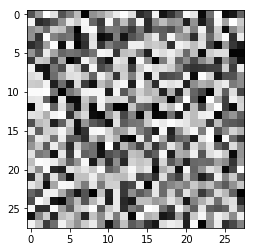

In [0]:
# Noise Input:

noise = np.random.rand(1,28,28,3)
print(noise.shape)
plt.imshow(noise[0,:,:,2],cmap='Greys')


In [0]:
#loading model weights
contrived = np.reshape(noise,(-1,28,28,3))
pred = model.predict(contrived[:0,:,:,1:2])
print(len(pred))
plt.imshow(pred[:],cmap='Greys')

In [0]:
im_list = list()
for im_gen in tfds.as_numpy(norm_test.take(2)):
  print(len(im_gen[1]))
  im_list.append(im_gen[1])
#   plt.imshow(im_gen[1][12][:,:,0],cmap='Greys')


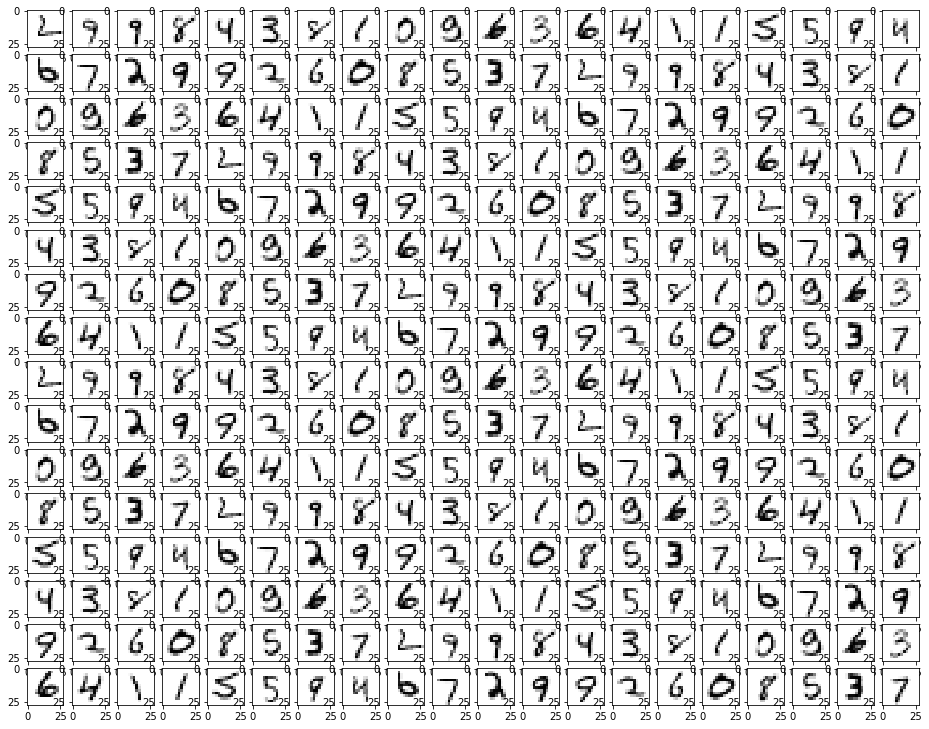

In [0]:
preds = model.predict(im_list,steps = 10)
m=0
plt.figure(figsize = (16,16))
for i in preds:
#   print(i.shape)
  plt.subplot(20, 20, m+1)
  m += 1 
  plt.imshow(i[:,:,0],cmap='Greys')
#   break
#   plt.subplot(20, 20, m+1)
#   plt.imshow(i[:,:,0],cmap='Greys')
